In [1]:
!pip install sklearn-genetic

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import ast
import math
import random
import pickle
import numpy as np
import pandas as pd
from numpy import std
from numpy import nan
from numpy import mean
from scipy.spatial import distance

In [3]:
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt

In [4]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from genetic_selection import GeneticSelectionCV as GA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare Data

In [5]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
origin = pd.read_csv('origin.csv')
origin_TDM = pd.read_csv('5_TDM_origin.csv')
origin_CON = pd.read_csv('5_CON_origin.csv')

In [6]:
train_X = train.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
train_y = train[['Sofa']]
train_pat = train[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
test_X = test.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
test_y = test[['Sofa']]
test_pat = test[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
origin_X = origin.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
origin_y = origin[['Sofa']]
origin_pat = origin[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originTDM_X = origin_TDM.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originTDM_y = origin_TDM[['Sofa']]
originTDM_pat = origin_TDM[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]
originCON_X = origin_CON.drop(columns = ['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead', 'Sofa'])
originCON_y = origin_CON[['Sofa']]
originCON_pat = origin_CON[['rno', 'Visite_day', 'Randomization group (1_TDM 2_Control)', 'dead']]

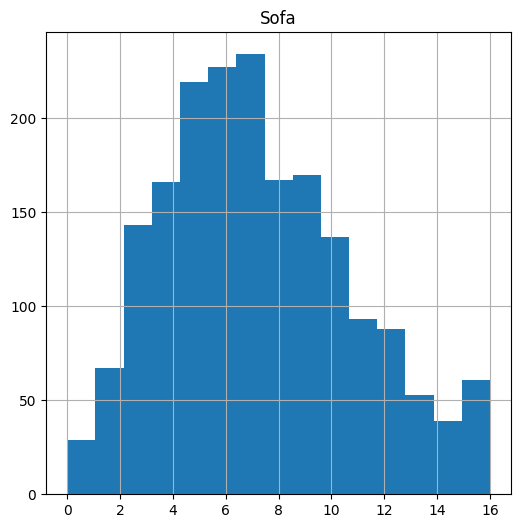

In [7]:
train_y.hist(bins=15, figsize=(6,6))
plt.show()

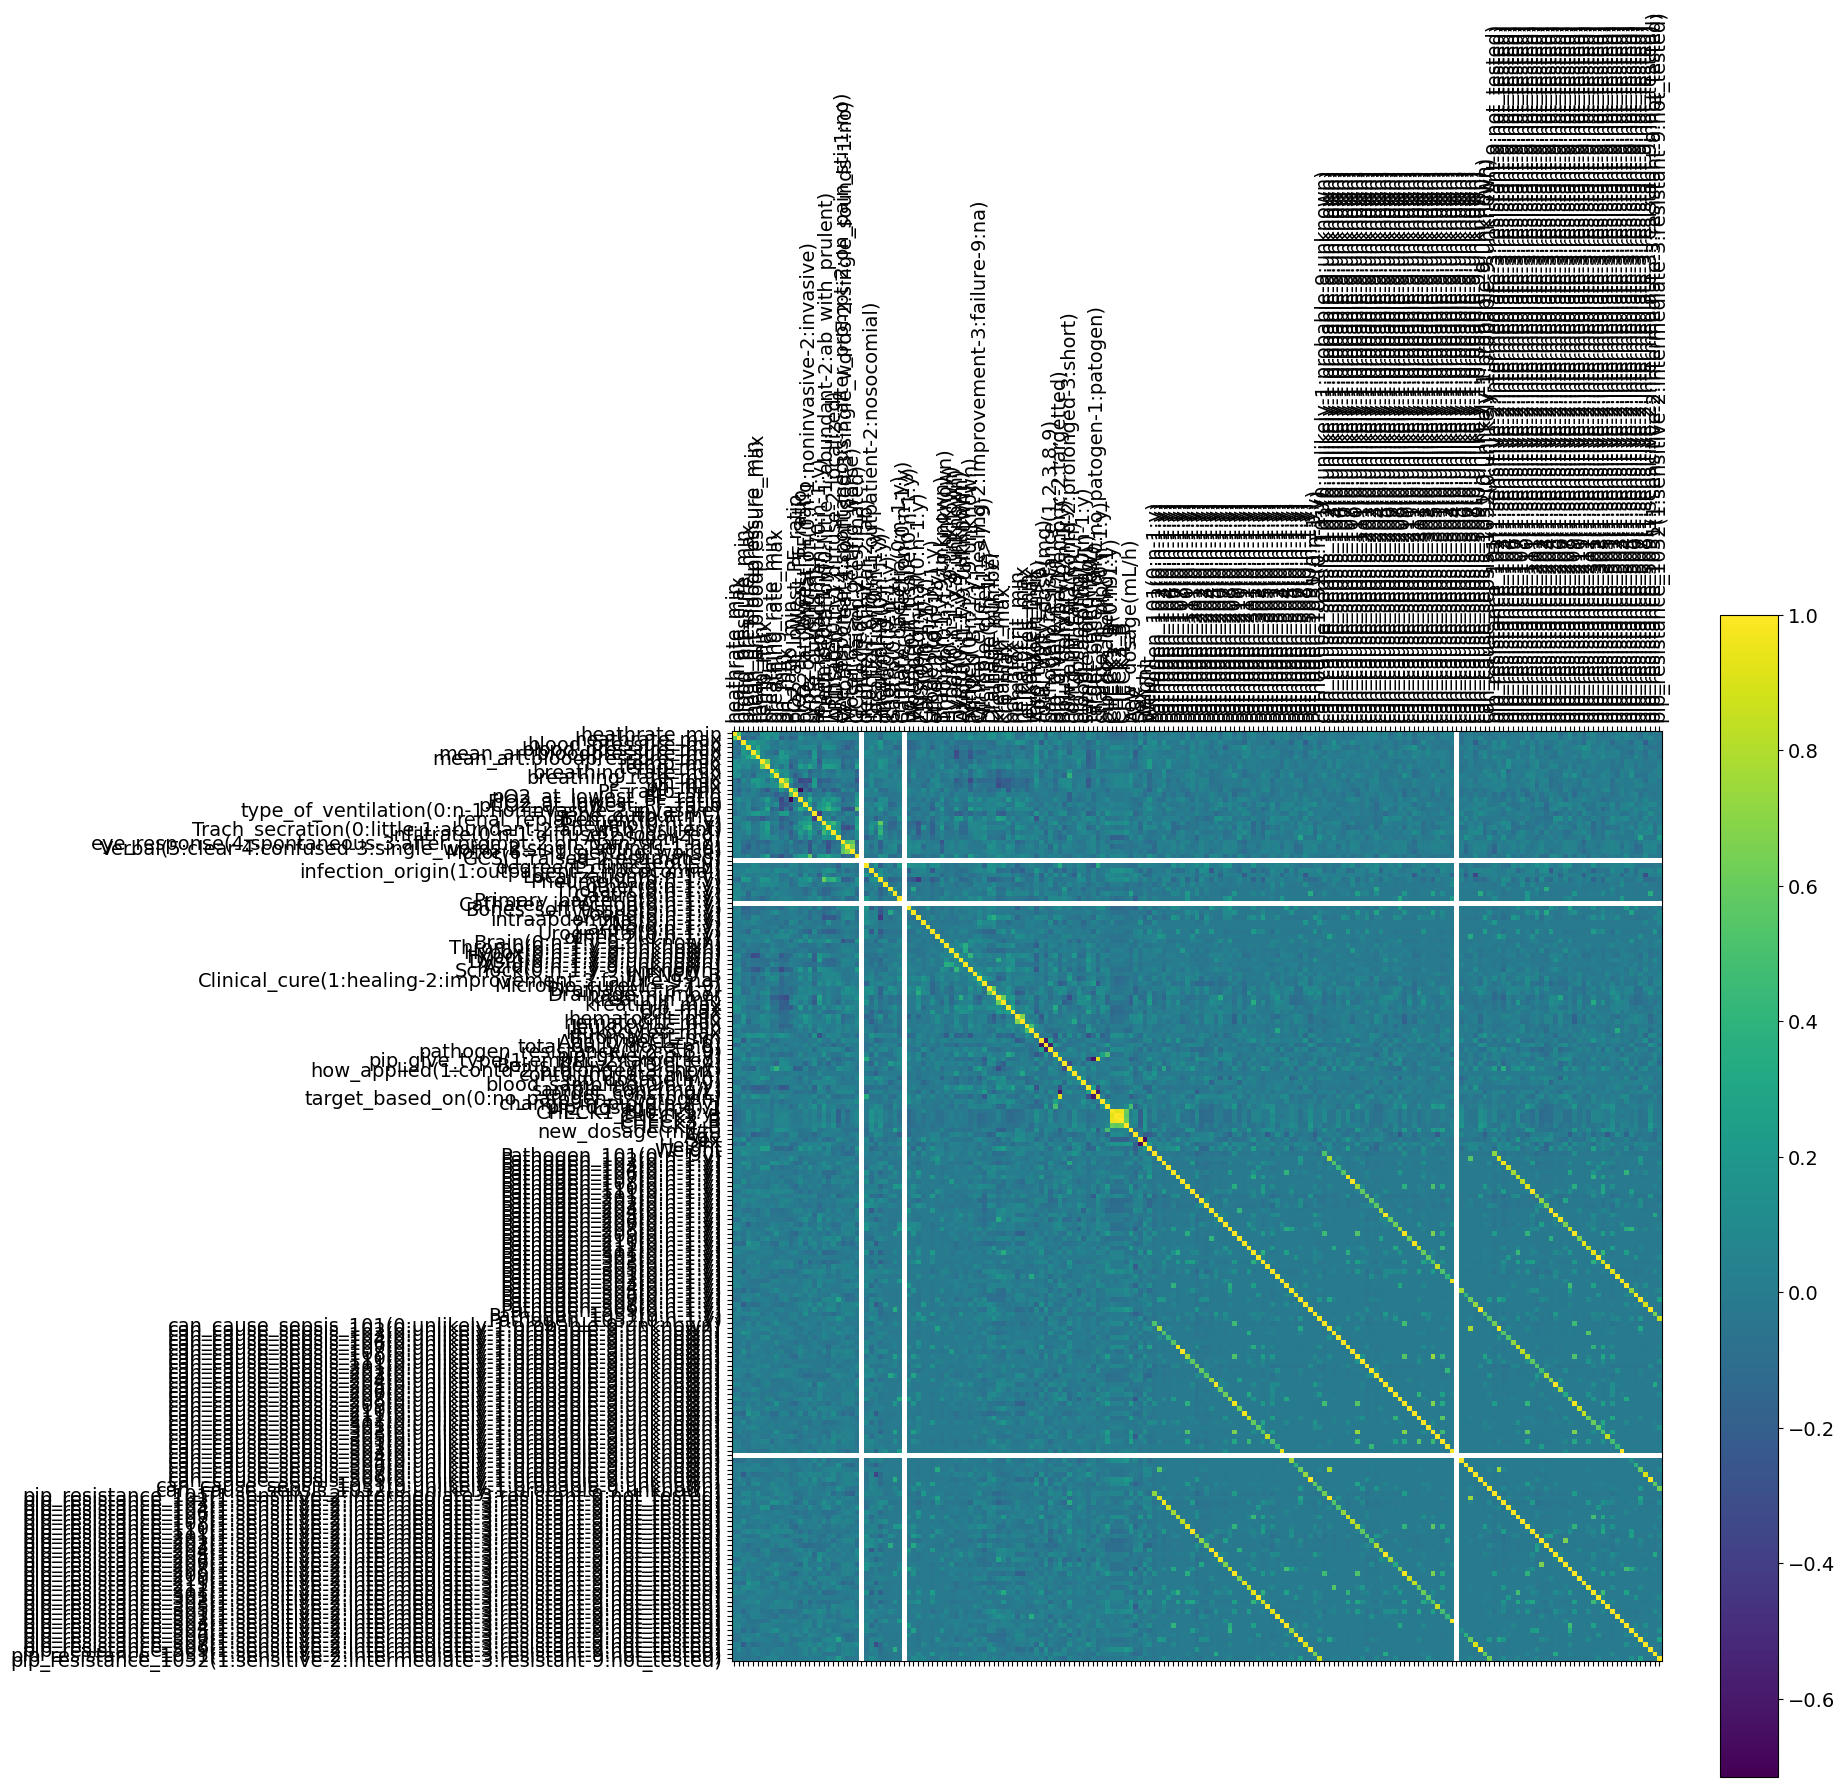

In [8]:
correlationMatrix = train_X.corr() 
f = plt.figure(figsize=(15, 15))
plt.matshow(correlationMatrix, fignum=f.number)
plt.xticks(range(train_X.shape[1]), train_X.columns, fontsize=14, rotation=90)
plt.yticks(range(train_X.shape[1]), train_X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show()

# Feature Selection GA

In [9]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
# evaluate the models and store results
results = []
names = []
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for i in range(40, 50):
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.554429 20.684848  0.204128]	[  0.334685  11.603451   0.078872]	[-3.366534  1.        0.040486]	[-1.867617 40.        0.411842]
1  	88    	[-426.4199     27.709091  424.413689]	[ 2015.091892     8.733785  2015.514152]	[-10000.            3.            0.046912]	[   -1.73595    44.      10000.     ]
2  	96    	[-183.837487   30.527273  181.968295]	[ 1335.810536     6.417366  1336.064888]	[-10000.            5.            0.058668]	[   -1.597714    44.       10000.      ]
3  	94    	[-426.079099   31.109091  424.373655]	[ 2015.163614     6.342754  2015.522578]	[-10000.           17.            0.036974]	[   -1.53658    47.      10000.     ]   
4  	95    	[-668.359853   31.593939  666.786343]	[ 2493.985739     5.996865  2494.406273]	[-10000.           17.            0.027556]	[   -1.53658    4

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>40 -1.088 (0.067)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.543653 20.745455  0.201688]	[  0.344828  11.581937   0.079327]	[-3.402645  1.        0.04859 ]	[-1.806236 41.        0.519867]
1  	86    	[-123.458535   28.218182  121.386026]	[ 1094.022109     8.694877  1094.251653]	[-10000.            1.            0.023489]	[   -1.668204    44.       10000.      ]
2  	82    	[-244.460712   31.2       242.580077]	[ 1537.68842      6.791438  1537.984837]	[-10000.           16.            0.023489]	[   -1.625476    48.       10000.      ]
3  	78    	[-486.705226   31.333333  484.993937]	[ 2147.46514      6.624412  2147.851428]	[-10000.           10.            0.023489]	[   -1.616643    47.       10000.      ]
4  	87    	[-123.008215   30.654545  121.352539]	[ 1094.071974     4.794763  1094.255361]	[-10000.           10.            0.023489]	[   -1.499321 

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>41 -1.014 (0.073)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.


Process ForkPoolWorker-26:
Process ForkPoolWorker-30:
Process ForkPoolWorker-29:
Process ForkPoolWorker-21:
Process ForkPoolWorker-27:
Process ForkPoolWorker-24:
Process ForkPoolWorker-28:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-25:

KeyboardInterrupt

Process ForkPoolWorker-33:
Process ForkPoolWorker-32:
Process ForkPoolWorker-34:
Process ForkPoolWorker-35:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/kit/its/co9863/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kit/its/co

In [9]:
with open('results.pickle', 'rb') as file:
    results = pickle.load(file)
    
with open('names.pickle', 'rb') as file:
    names = pickle.load(file)

In [ ]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
for i in range(48, len(train_X.columns) + 1):
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results.append(scores)
    names.append(i)
    with open('results.pickle', 'wb') as file:
        pickle.dump(results, file)
    with open('names.pickle', 'wb') as file:
        pickle.dump(names, file)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.463015 24.745455  0.196606]	[  0.376396  14.045663   0.077902]	[-3.602879  1.        0.058388]	[-1.626564 48.        0.536486]
1  	105   	[-244.507897   33.872727  242.58952 ]	[ 1537.680989     9.227865  1537.983349]	[-10000.            3.            0.036463]	[   -1.626564    52.       10000.      ]
2  	89    	[-123.144528   36.375758  121.368901]	[ 1094.056877     6.820958  1094.253549]	[-10000.           20.            0.043072]	[   -1.585482    51.       10000.      ]
3  	82    	[-123.008657   38.515152  121.357181]	[ 1094.071921     5.85233   1094.254847]	[-10000.           20.            0.043072]	[   -1.559358    51.       10000.      ]
4  	85    	[-122.915349   39.551515  121.356478]	[ 1094.082254     5.158583  1094.254925]	[-10000.           24.            0.054858]	[   -1.46952  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>48 -1.026 (0.060)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.418798 26.024242  0.187016]	[  0.349637  14.786133   0.063371]	[-3.28961   1.        0.072216]	[-1.763212 49.        0.383606]
1  	69    	[-123.319993   34.29697   121.38102 ]	[ 1094.03745     10.955128  1094.252207]	[-10000.            2.            0.072216]	[   -1.65682    53.      10000.     ]
2  	93    	[-547.320368   38.351515  545.602551]	[ 2270.460215     8.246069  2270.872814]	[-10000.           15.            0.032677]	[   -1.562859    57.       10000.      ]
3  	86    	[-426.023356   38.890909  424.388664]	[ 2015.175346     7.006506  2015.519419]	[-10000.           22.            0.052156]	[   -1.511884    56.       10000.      ]
4  	87    	[-244.132077   39.539394  242.563107]	[ 1537.740212     6.317361  1537.987511]	[-10000.           24.            0.041319]	[   -1.423333    

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>49 -1.036 (0.067)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.498926 23.866667  0.204433]	[  0.324079  14.188144   0.072555]	[-3.402295  1.        0.044712]	[-1.750659 50.        0.461951]
1  	97    	[-123.396222   32.466667  121.3931  ]	[ 1094.029011    11.581874  1094.25087 ]	[-10000.            6.            0.059451]	[   -1.664552    53.       10000.      ]
2  	81    	[-365.573064   38.715152  363.78385 ]	[ 1871.556544     8.036889  1871.904104]	[-10000.           18.            0.028814]	[   -1.567691    56.       10000.      ]
3  	95    	[-304.866154   41.042424  303.164737]	[ 1713.873729     6.031585  1714.174493]	[-10000.           25.            0.054686]	[   -1.508133    53.       10000.      ]
4  	79    	[-183.54839    42.854545  181.940325]	[ 1335.849869     4.609943  1336.068693]	[-10000.           26.            0.043362]	[   -1.508133 

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>50 -1.064 (0.059)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.474812 25.369697  0.194003]	[  0.374833  15.862372   0.066876]	[-3.49053   1.        0.064554]	[-1.672032 51.        0.444681]
1  	85    	[-123.337414   34.49697   121.390121]	[ 1094.035528    11.908553  1094.251199]	[-10000.            1.            0.055178]	[   -1.658162    53.       10000.      ]
2  	67    	[-183.733319   41.381818  181.978245]	[ 1335.824709     7.420261  1336.063533]	[-10000.           13.            0.067395]	[   -1.531934    55.       10000.      ]
3  	93    	[-789.556462   43.515152  788.015904]	[ 2693.583403     6.485047  2694.033934]	[-10000.           24.            0.062742]	[   -1.531934    58.       10000.      ]
4  	71    	[-304.699482   44.387879  303.167578]	[ 1713.90319      5.055555  1714.173991]	[-10000.           31.            0.060765]	[   -1.48128  

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>51 -1.044 (0.063)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.447609 25.648485  0.191152]	[  0.34049   15.047322   0.067833]	[-3.322391  1.        0.029754]	[-1.776932 52.        0.36851 ]
1  	99    	[-62.723833  35.593939  60.776744]	[ 775.970937    9.588438  776.122946]	[-10000.           4.           0.04182]	[   -1.680909    55.       10000.      ]
2  	86    	[-62.551656  38.10303   60.763617]	[ 775.984366    7.674929  776.12397 ]	[-10000.           14.            0.052754]	[   -1.529289    55.       10000.      ]
3  	88    	[-123.012073   40.006061  121.36436 ]	[ 1094.071544     6.942619  1094.254052]	[-10000.           26.            0.058035]	[   -1.492331    59.       10000.      ]
4  	82    	[-304.690144   40.515152  303.176683]	[ 1713.904841     6.53439   1714.172381]	[-10000.           27.            0.053136]	[   -1.472116    59.       10

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>52 -1.043 (0.066)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.417084 26.945455  0.185606]	[  0.35938   15.479118   0.065233]	[-3.285398  1.        0.055324]	[-1.78596  53.        0.455948]
1  	87    	[-2.104003 35.884848  0.171261]	[  0.237275  10.21372    0.059036]	[-2.979776  1.        0.063744]	[-1.78596  53.        0.326834]
2  	74    	[-62.534977  38.90303   60.762366]	[ 775.985666    8.16439   776.124068]	[-10000.           17.            0.041441]	[   -1.535546    55.       10000.      ]
3  	84    	[-183.609734   41.981818  181.966364]	[ 1335.84152     7.08175  1336.06515]	[-10000.           24.            0.044027]	[   -1.535546    55.       10000.      ]
4  	98    	[-122.93852    43.090909  121.354645]	[ 1094.07969      6.073108  1094.255128]	[-10000.           26.            0.043199]	[   -1.497017    57.       10000.      ]
5  	81    	[-36

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>53 -1.063 (0.057)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.387717 29.260606  0.189714]	[  0.365961  15.267274   0.070591]	[-3.463966  1.        0.055316]	[-1.604699 54.        0.391619]
1  	104   	[-183.872399   37.842424  181.976638]	[ 1335.805791     9.386613  1336.063752]	[-10000.            9.            0.053669]	[   -1.604699    64.       10000.      ]
2  	93    	[-1.911249 39.981818  0.14661 ]      	[ 0.199751  7.420261  0.048907]         	[-2.477125 18.        0.065974]            	[-1.551803 53.        0.324945]         
3  	91    	[-62.351184  41.218182  60.732827]   	[ 776.000016    6.181176  776.126374]   	[-10000.           21.            0.044703]	[   -1.514518    55.       10000.      ]
4  	94    	[-62.249187  42.181818  60.71632 ]   	[ 776.007971    6.142029  776.127662]   	[-10000.           25.            0.044703]	[   -1.452355 

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>54 -1.026 (0.065)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                            
0  	165   	[-2.419099 27.630303  0.194185]	[  0.362088  16.267918   0.078045]	[-3.331013  1.        0.052946]	[-1.584144 55.        0.455871]
1  	80    	[-62.689574  39.218182  60.778378]	[ 775.973622   10.603643  776.122819]	[-10000.           10.            0.049843]	[   -1.581183    57.       10000.      ]
2  	85    	[-244.267494   41.278788  242.56281 ]	[ 1537.718876     9.051093  1537.987558]	[-10000.          17.           0.04271]   	[   -1.520204    59.       10000.      ]


In [9]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
results_ = []
names_ = []
inds = [100, 150, 200]
for i in inds:
    model = GA(estimator, cv=5, verbose=1, scoring='neg_mean_absolute_error', max_features=i, n_population=165, 
               crossover_proba=0.5, mutation_proba=0.05, n_generations=100, crossover_independent_proba=0.5, 
               mutation_independent_proba=0.04, tournament_size=3, n_gen_no_change=10, caching=True, n_jobs=-1)
    model = model.fit(X, y)
    X_selection = X[X.columns[model.support_].tolist()]
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X_selection, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results_.append(scores)
    names_.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results_, labels=names_, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                               
0  	165   	[-2.151626 51.175758  0.177721]	[  0.398112  27.558852   0.062413]	[-3.252988  1.        0.060388]	[ -1.457844 100.         0.383007]
1  	102   	[-123.020492   71.193939  121.357228]	[ 1094.07062     17.057797  1094.254842]	[-10000.           20.            0.043801]	[   -1.457844   104.       10000.      ]
2  	80    	[-183.453665   79.806061  181.959182]	[ 1335.86276     13.27239   1336.066127]	[-10000.           45.            0.043801]	[   -1.457844   105.       10000.      ]
3  	87    	[-62.170652  82.890909  60.741927]   	[ 776.014101   10.708829  776.125663]   	[-10000.           52.            0.040142]	[   -1.442458   101.       10000.      ]
4  	86    	[-62.110687  87.175758  60.731057]   	[ 776.018781    7.268822  776.126511]   	[-10000.           61.            0.040142]	[   -1.4

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>100 -1.050 (0.062)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Selecting features with genetic algorithm.
gen	nevals	avg                            	std                               	min                            	max                               
0  	165   	[-1.96985  78.024242  0.167094]	[  0.391577  42.333159   0.058992]	[-3.279796  1.        0.056513]	[ -1.462217 149.         0.367984]
1  	79    	[-62.25499  109.224242  60.749899]	[ 776.007523   22.080391  776.12504 ]	[-10000.           40.            0.056513]	[   -1.459131   153.       10000.      ]
2  	73    	[ -1.561541 117.939394   0.136552]	[  0.073061  18.445562   0.034685]   	[-1.784822 64.        0.056774]            	[ -1.450599 149.         0.221985]      
3  	102   	[ -1.499368 117.230303   0.134743]	[  0.034589  16.995052   0.034438]   	[-1.641187 64.        0.030538]            	[ -1.425231 146.         0.221985]      
4  	71    	[ -1.47458  113.89697    0.130158]	[  0.026805  17.089293   0.035287]   	[-1.602743 64.        0.030538]            	[ -1.412573 145.         0.19169

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>150 -1.032 (0.060)


/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: 'max_features' should be between 1 and 197 features. Got 200 instead.

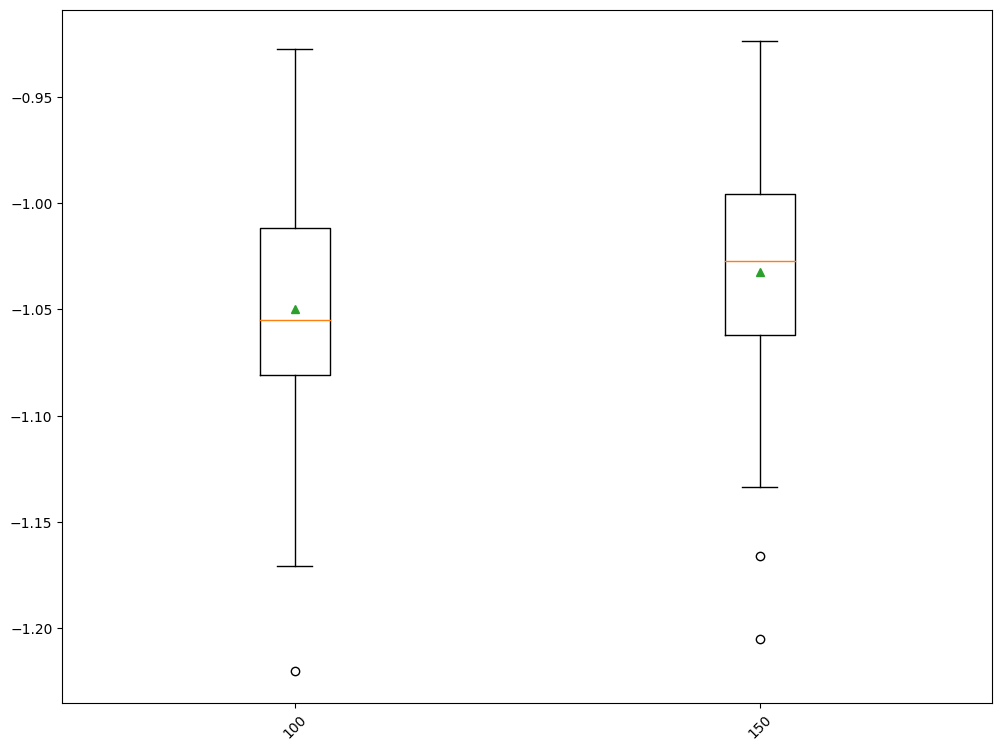

In [10]:
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results_, labels=names_, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tensorflow/2023-03-24/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/bwhpc/common/jupyter/tenso

>197 -1.000 (0.076)


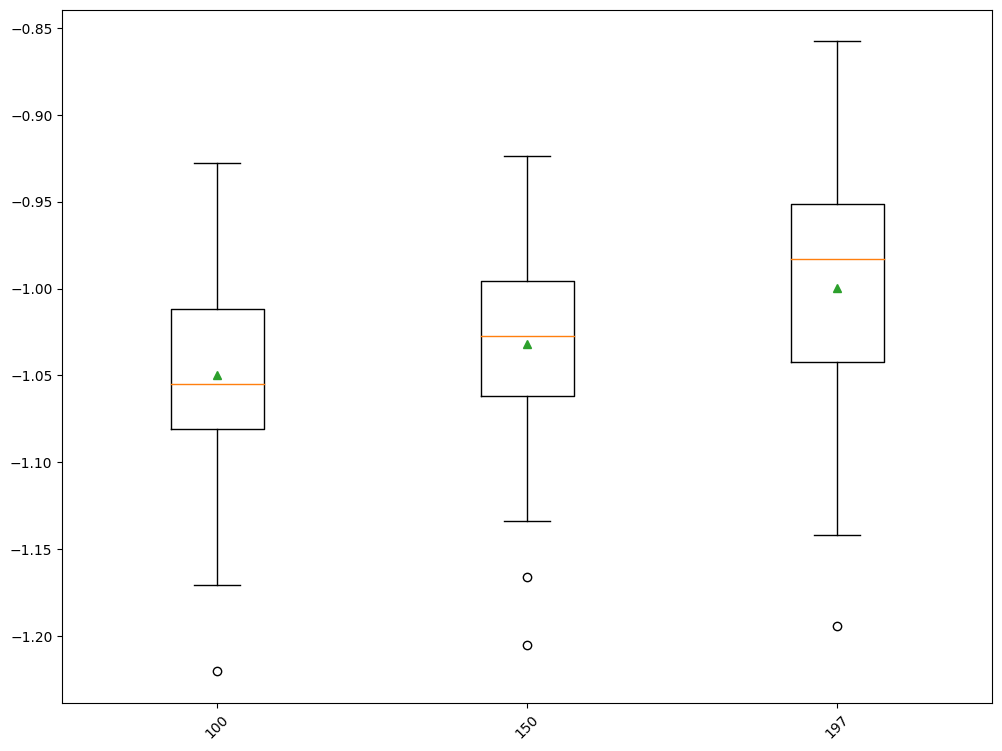

In [12]:
X = train_X
y = train_y
y = y.astype('float')
estimator = RandomForestRegressor()
kf = KFold(n_splits=10, shuffle=True, random_state=1)
inds = [197]
for i in inds:
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(RandomForestRegressor(), X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    results_.append(scores)
    names_.append(i)
    print('>%s %.3f (%.3f)' % (i, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.figure(figsize =(12, 9))
pyplot.boxplot(results_, labels=names_, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()